Ce notebook montre la mise en oeuvre d'un problème de classification supervisée sur des données numériques (dataset iris) :

- à l'aide d'un algorithme de classification supervisée (knn)
- à l'aide d'un algorithme de classification non supervisée (Kmeans).
- à l'aide d'un réseau dense de classification (entrainement et tests)
- à l'aide d'un réseau dense de régression (en abordant donc ce problème de classification comme un problème de régression, à des fins d'illustration de la mise en oeuvre d'un problème de régression par réseau de neurones).

Les sections du cours en ligne
https://www.oliviergibaru.org/courses/MachineLearning.html
en lien avec l'activité sont

*   Neural Network with Keras : partie Keras Dense Neural Network
*   Supervised Classification : parties Introduction et K-nearest neighbors Algorithm
*   Unsupervised Classification : parties Introduction et K-means Algorithm



Les grandes lignes de la méthodologie d'un problème de classification supervisée sont les suivantes :

1. Transformation en données numériques si ce n'est pas déjà le cas (Données textuelles en "word2vect", signaux audio en spectrogramme = image ou FFT = vecteur numérique par exemples).  
2.   **Séparation des données labelisées (X,Y) en données d'entraînement (Xtrain,Ytrain) et de test (Xtest,Ytest)**
3.   (si modèle = réseau de neurones) : mise en forme des données
(entrée = tenseur, sortie = vecteur), dont la mise en forme des sorties via "to_categorical"
4.   (si modèle = réseau de neurones) : créer le modèle i.e. l'architecture du réseau, ici sous Python/Keras, puis compiler le modèle (choix de l'optimizer, de la fonction de loss)
5.   **entrainement** du modèle : **model.fit(Xtrain,Ytrain)**.
Pour un réseau de neurones : contrôler l'évolution de la loss et de l'accuracy au cours des époques sur les données de train et de test pour vérifier qu'il n'y a pas d'overfitting (sinon, stopper l'entraînement en cours) puis sauvegarder le jeu de poids obtenu.
6. Analyse des performances du modèle, qui se fait sur des données de **test**  "labélisées" qui ne font pas partie des données d'entraînement
: **Ypred=model.predict(Xtest) et comparaison de Ypred avec les vrais label Ytest**.
La **matrice de confusion :  confusion_matrix(Ytest,Ypred)**
fournie un bel outil, très simple, d'analyse des performances.



A retenir :

Il convient de **séparer les données labélisées (X,Y)** en :
- **des données de train (Xtrain,Ytrain)  -> pour l'entraînement : model.fit(Xtrain,Ytrain)**
- **des données de test (Xtest,Ytest)     -> pour évaluer les performances du modèle : Ypred=model.predict(Xtest) et comparaison des prédictions Ypred avec les labels Ytest**
afin devérifier que le modèle (algorithme, réseau de neurones, ...)
est capable de généraliser à de nouvelles données sur lesquelles il n'a pas été réglé/entrainé. En effet, une bonne accuracy de fit n'est pas forcement synonyme d'un algorithme / réseau de neurones performant !
De l'overfitting a pu se produire. C'est pourquoi, il faut garder des données labélisées pour le test avant d'utiliser cet algorithme / réseau de neurones pour réellement faire des prédictions.

**La matrice de confusion est un très bel outil pour analyser les résultats sur ces données de test**.
La diagonale d'une matrice de confusion correspond aux bonnes prédictions (accuracy de test).
Elle permet de voir en plus si des confusions se produisent plus spécifiquement entre certaines classes.


# Packages utiles et configuration du Drive

In [ ]:
# Importation de packages utiles

import sklearn  # https://scikit-learn.org/
import sklearn.datasets as ds    # librairie de datasets, qui contient notamment le dataset iris
import sklearn.neighbors as knn  # classification supervisée : algorithme des k plus proches voisins
import sklearn.cluster as clstr  # classification non supervisée (clustering : clstr) dans laquelle se trouve l'algorithme K-means


import tensorflow as tf
import keras                                             # bibliothèque Python pour la création de réseaux de neurones (il est contenu dans tensorflow, d'où l'import précédent)
from keras.models import Sequential, Model               # pour créer un modèle (un réseau de neurones) sous Keras
from keras.layers import Dense, Dropout, Activation      # couches classiques d'un réseau dense
from keras.utils import to_categorical                   # pour mise en format des labels(sorties) dans le cas d'un problème de classification
from sklearn.metrics import confusion_matrix             # outil d'analyse des résultats/performances pour un problème de classification

import sklearn.datasets as ds                            # librairie de datasets, qui contient notamment le dataset iris

import sklearn.neighbors as knn                          # Algorithme de classification supervisée (k plus proches voisins)
import sklearn.cluster as clstr                          # Bibliothèque pour la classification non supervisée (clustering : clstr) dans laquelle se trouve l'algorithme K-means

import numpy as np
from random import randint

import matplotlib.pyplot as plt

In [ ]:
# Packages pour la configuration et l'accès au Drive
import os
from google.colab import drive
from pathlib import Path

#######################################################################################
# renseignez le chemin vers le dossier de travail
# dans lequel seront déposés les datasets et les résultats : jeux de poids, graphiques
# Il reste juste à choisir le nom que vous voulez pour le working_dir
# (i.e. renommer PJT-ML)
######################################################################################
working_dir = 'drive/MyDrive/PJT-ML'
data_dir=str(working_dir)+"/DataSets"

def init_drive():
  # point de montage de google drive dans google colab
  drive.mount('drive', force_remount=True)
  # création du dossier de travail si celui-ci n'existe pas
  if not os.path.exists(working_dir):
    os.mkdir(working_dir)

init_drive()

Mounted at drive


# Quelques fonctions utiles fournies

- **Evolution de l'entrainement** :
 **summarize_diagnostics(history,directory,filename)**

Pour visualiser l'entrainement du réseau, nous avons défini une procédure qui crée et sauvegarde dans le Drive un graphique représentant l'évolution, au cours des époques :
  
(cas d'un problème de classification) des valeurs de la fonction de perte (loss) et d'accuracy (taux de bonnes prédictions)
pour les données d'entrainement et de test.

(cas d'un problème de regression) des valeurs de la fonction de perte (loss) pour les données d'entrainement et de test.

- Personnalisation du tracé d'une matrice de confusion :

 **plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False)**

- Composition d'un dataset = Nombre d'occurrences dans chacune des classes :

 **OccurencesClasses(Labels,NbClasses)**

In [ ]:
def summarize_diagnostics_classif(history,directory,filename):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    # save plot to file
    plt.savefig("{}/{}_plot.png".format(directory,filename))
    plt.show()
    plt.close()

In [ ]:
def summarize_diagnostics_reg(history,directory,filename):
    # plot loss
    plt.title('Regression Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend()
    # save plot to file
    plt.savefig("{}/{}_plot.png".format(directory,filename))
    plt.show()
    plt.close()

(Pour un problème de classification) **Matrice de confusion** : " cm=confusion_matrix(Ylabels,Ypredictions)"

La diagonale d'un matrice de confusion correspond donc aux bonnes prédictions, et elle permet en particulier de voir si des confusions se produisent plus spécifiquement entre certaines classes.
En recherchant sur internet (par exemple "confusion matrix Keras", "confusion matrix plot"), vous trouverez de nombreux sites sur le sujet, qui vous présentent cet outils et vous montre comment tracer une matrice de confusion et personnaliser ce tracé à vos souhaits. Par exemples :

https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics (section 3.3.2.6)

https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

Ci-dessous une fonction permettant de personnaliser le tracé d'une matrice de confusion

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


Composition d'un dataset = Nombre d'occurrences dans chacune des classes : **OccurencesClasses(Labels,NbClasses)**
Cette fonction est utile pour vérifier si un dataset est suffisamment homogènes (répartition à peu près similaire dans chacune des classes)

In [ ]:
def OccurencesClasses(Labels,NbClasses):
  Occ=np.zeros(NbClasses,int)
  for i in range(len(Labels)):
    Occ[Labels[i]]+=1;
  return(Occ)

# Chargement du dataset Iris - Visualisation des caractéristiques (features) et labels

In [ ]:
### chargement du  dataset Iris ###
# informations https://archive.ics.uci.edu/ml/datasets/iris
iris = ds.load_iris()
features_iris = iris.data  # caractéristiques (features) dimension 4 : [sepal length in cm, sepal width in cm, petal length in cm, petal width in cm]
target_iris= iris.target # 3 classes : Iris Setosa, Iris Versicolour, Iris Virginica / label = {0,1,2}
# 50 instances de chaque classe
print("shape features=",np.shape(features_iris),",  shape label=",np.shape(target_iris)) # donc dimensions : features = (150,4), label = (150,1)


shape features= (150, 4) ,  shape label= (150,)


In [ ]:
print("features:\n",features_iris)

features:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 

In [ ]:
print("Labels:\n",target_iris)
# Nous remarquons que les données sont ordonnées par classe (i.e. non mélangées)

Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


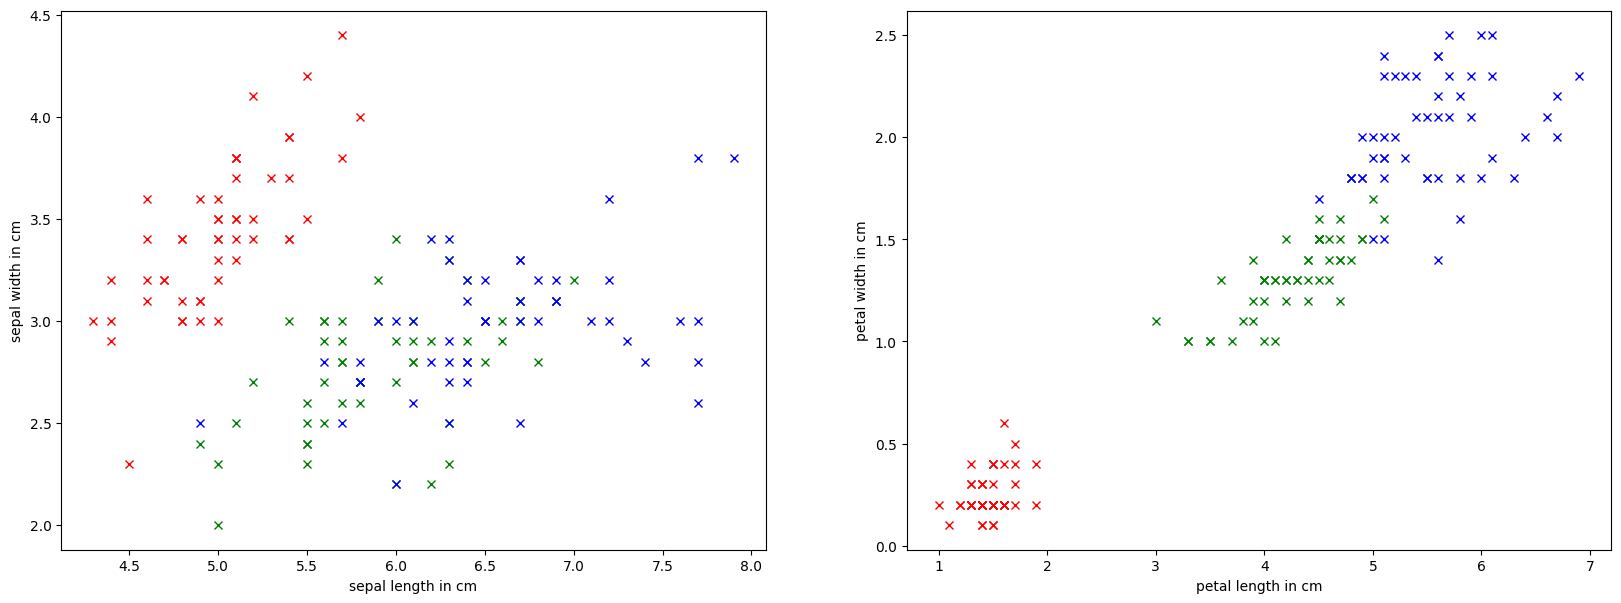

In [ ]:
StylePlot=['xr','xg','xb']  #croix rouge,verte,bleue pour visualiser d'une couleur différente les données de chacune des 3 classes

plt.figure(1, figsize=(20,7))

# représentation des 2 premiers features (longueur et largeur des sépales)
plt.subplot(121)
for i in range(len(features_iris)):
  plt.plot(features_iris[i][0],features_iris[i][1],StylePlot[target_iris[i]])
plt.xlabel('sepal length in cm')
plt.ylabel('sepal width in cm')
# représentation des 2 features suivants (longueur et largeur des pétales)
plt.subplot(122)
for i in range(len(features_iris)):
  plt.plot(features_iris[i][2],features_iris[i][3],StylePlot[target_iris[i]])
plt.xlabel('petal length in cm')
plt.ylabel('petal width in cm')
plt.show()




Nous remarquons que les features des Iris Setosa (classe=0, croix rouge) sont bien séparés de ceux des autres classes.

Nous nous attendons donc à ne pas voir de confusions sur cette classe.   

# Classification supervisée : Algorithme des k plus proches voisins de scikit-learn. Application sur dataset Iris

In [ ]:
# Mélange des données car les données sont organisées par ordre de classe (0,1,2)
# Il faut faire attention à bien melanger de la même manière l'ordre des caractéristiques (features) et des labels !
# Astuce : mélanger les indices et appliquer ce même mélange aux deux listes : features_iris et target_iris

randomized_indices = np.arange(len(target_iris))  # liste des indices : [0,1,...,149]
np.random.shuffle(randomized_indices)  # application de la méthode pour mélanger
print("mélange aléatoire des indices : \n",randomized_indices)
#Iris dataset apès mélange
shuffled_features_iris = features_iris[randomized_indices]
shuffled_target_iris = target_iris[randomized_indices]

mélange aléatoire des indices : 
 [142  12 134 112 107 106  18  46  87  14  98  67 120 101  41  72  83 103
 115 147 123  96  47  45  69 118  60  88 126  58  31  38 113  54  56 141
   9  80  91  26  66  22  10  78 145  34  40 140 125   1  28 144   2  29
  19 132  61 128 143 100   8  74  27 111  30  73  53  85   0  17  32  62
  92  71  99 127  43  59  89 108   6  79 149 148  82  13  42  24  51  35
 119 109  50  52  97  84  77  94 121  95   4 117 105  65   5 114 102 136
  16 122 135 110  36  63  25  23  81  75 146  68 138 116  93  11  21   7
  33 139  90 137 130  55  20 129 133   3  57  44 131  64 104  37  86  49
  70 124  39  76  48  15]


In [ ]:
# Séparation en données de train (fit) et de test (predict)
tot=len(target_iris) #150 données
N=100   # Nombre de données pour l'algorithme (model.fit) parmi les 150 instances / les nb_voisins les plus proches seront donc choisis parmis ces N datas
Nclasses=3
Xtrain, Ytrain = shuffled_features_iris[0:N], shuffled_target_iris[0:N]
Xtest, Ytest = shuffled_features_iris[N:tot], shuffled_target_iris[N:tot]

print('Occurences par classes:')
print('Train :', OccurencesClasses(Ytrain,Nclasses))
print('Test :', OccurencesClasses(Ytest,Nclasses))
# Nous vérifions que la réparition dans les bases de Train et de Test est suffisamment homogène
# (représentation similaire dans chacune des classes, disons à 2 unités près pour Train).
print('dimensions Xtrain, Ytrain :', np.shape(Xtrain),np.shape(Ytrain))
print('dimensions Xtest, Ytest :',np.shape(Xtest),np.shape(Ytest))

Occurences par classes:
Train : [32 37 31]
Test : [18 13 19]
dimensions Xtrain, Ytrain : (100, 4) (100,)
dimensions Xtest, Ytest : (50, 4) (50,)


In [ ]:
# Si ce n'est pas la cas, nous générons une nouvelle repartition aléatoire "shuffle" jusqu'à ce que la répartition soit homogène
# remarque : nous aurions pu faire une procédure pour séparer de manière homogène !
tolerance=2  #ecart max entre la classe la plus représentée et la moins représentée
occ=OccurencesClasses(Ytrain,Nclasses)
while max(occ)-min(occ)>tolerance :  # si la répartition n'est pas assez homogène :
  # shuffle
  randomized_indices = np.arange(len(target_iris))  # liste des indices : [0,1,...,149]
  np.random.shuffle(randomized_indices)  # application de la méthode pour mélanger
  #Iris dataset apès mélange
  shuffled_features_iris = features_iris[randomized_indices]
  shuffled_target_iris = target_iris[randomized_indices]
  Xtrain, Ytrain = shuffled_features_iris[0:N], shuffled_target_iris[0:N]
  Xtest, Ytest = shuffled_features_iris[N:tot], shuffled_target_iris[N:tot]
  occ=OccurencesClasses(Ytrain,Nclasses)

print('Occurences par classes:')
print('Train :', OccurencesClasses(Ytrain,Nclasses))
print('Test :', OccurencesClasses(Ytest,Nclasses))


Occurences par classes:
Train : [33 33 34]
Test : [17 17 16]


In [ ]:
# construction du modèle
nb_voisins=10 #choix du paramètre k=nombre de voisins
model = knn.KNeighborsClassifier(n_neighbors=nb_voisins)  # Remarque : par défaut n_neighbors=5, ici réglé à nb_voisins.

#fit du modèle sur la connaissance des N=100 données labélisées
model.fit(Xtrain,Ytrain)

# prédictions sur les tot-N=150-100=50 gardées pour les tests.
Ypred=model.predict(Xtest)

print('predictions')
print(Ypred)
print('labels')
print(Ytest)

# calcul de l'accuracy
err=0
Ntest=tot-N #nombre de données de test
for i in range(Ntest):
    if Ypred[i] != Ytest[i] :  # si mauvaise prédiction :
            err += 1
print('erreurs = ',err,'/',Ntest,' donc accuracy = ',(Ntest-err)/Ntest*100,'%')


predictions
[0 0 1 1 1 2 2 0 1 2 0 0 2 0 1 1 0 1 0 2 1 1 0 0 1 2 0 2 1 2 0 1 0 1 1 2 2
 2 2 2 0 2 2 0 1 0 2 1 2 0]
labels
[0 0 1 1 1 2 2 0 1 2 0 0 2 0 1 1 0 1 0 2 1 1 0 0 1 2 0 2 1 2 0 1 0 1 1 1 2
 2 2 2 0 2 2 0 1 0 2 1 2 0]
erreurs =  1 / 50  donc accuracy =  98.0 %


In [ ]:
# synthèse des résulats sous forme d'une matrice de confusion
from sklearn.metrics import confusion_matrix
cm_iris=confusion_matrix(Ytest,Ypred)
print('matrice de confusion=\n',cm_iris)

matrice de confusion=
 [[17  0  0]
 [ 0 16  1]
 [ 0  0 16]]


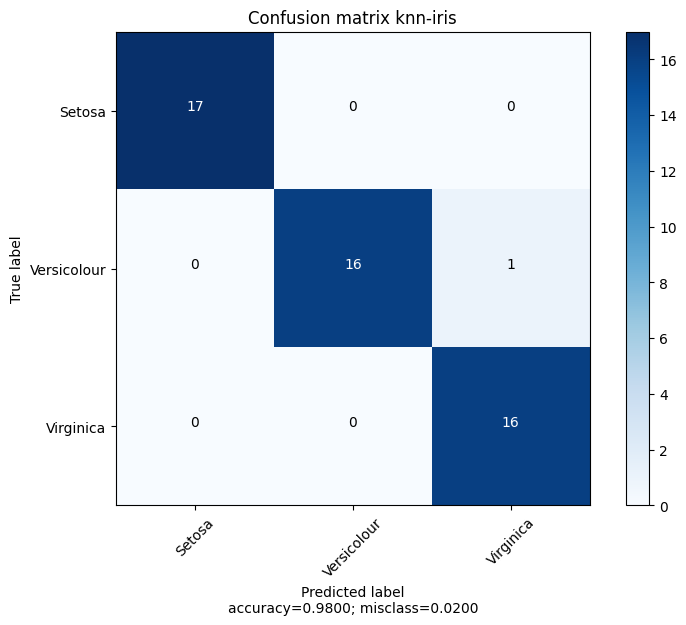

In [ ]:
labelname=['Setosa', 'Versicolour', 'Virginica'] # pour afficher le nom des classes plutôt que le N°
Mytitle='Confusion matrix knn-iris'
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cm_iris,target_names=labelname,title=Mytitle,cmap=Mycmap,normalize=False)
# normalize : 'False' = résultat en nombre d'occurences , 'True' = resultat en proportion pour chaque classe



Les éventuelles confusions apparaissent seulement entre les classes  Versicolour et Virginica (vous pouvez relancer plusieurs fois i.e. avec différents mélanges, et vérifier que c'est toujours le cas !)

C'est cohérent avec l'interprétation que nous avions fait en visualisant les features précédemment

In [ ]:
print('Rappel : occurences par classes (données de test) :', OccurencesClasses(Ytest,Nclasses))
# nous retrouvons bien ces nombres d'occurences en sommant chacune des lignes (true label)

Rappel : occurences par classes (données de test) : [17 17 16]


# Classification supervisée : Mise en oeuvre d'une 3-Fold validation sur le dataset Iris.

In [ ]:
#############################################################################
# K fold validation (ici K=3) :
# - splitter les données labéliséees en K=3 sous-ensembles de même taille (sub1, sub2, ..., subK)
# - prendre K-1=2 sous-ensembles pour le train et l'autre pour les test.
# - Tester les K=3 combinaisons différentes pour retenir la meilleure
#      train : sub1 and sub2 / test : sub3
#      train : sub1 and sub3 / test : sub2
#      train : sub2 and sub3 / test : sub1
##############################################################

Nclasses=3  #nombre de classes
tolerance=2  # Dans chaque sub, nous voulons une repartition suffisament homogène dans les classes

occ1=[tolerance+1,0]; occ2=occ1; occ3=occ1 # pour définir occ1,occ2,occ3 : une liste quelconque ne verifiant pas la "tolérance"

while ((max(occ1)-min(occ1)>tolerance) or (max(occ2)-min(occ2)>tolerance) or (max(occ3)-min(occ3)>tolerance)):

  randomized_indices = np.arange(len(features_iris))
  np.random.shuffle(randomized_indices)
  shuffled_features_iris = features_iris[randomized_indices]
  shuffled_target_iris = target_iris[randomized_indices]

  subfeatures1=shuffled_features_iris[0:50]
  subtarget1=shuffled_target_iris[0:50]

  subfeatures2=shuffled_features_iris[50:100]
  subtarget2=shuffled_target_iris[50:100]

  subfeatures3=shuffled_features_iris[100:150]
  subtarget3=shuffled_target_iris[100:150]

  occ1=OccurencesClasses(subtarget1,Nclasses)
  occ2=OccurencesClasses(subtarget2,Nclasses)
  occ3=OccurencesClasses(subtarget3,Nclasses)

print('composition')

print('Sub1 :', occ1)
print('Sub2 :', occ2)
print('Sub3 :', occ3)


composition
Sub1 : [17 16 17]
Sub2 : [16 18 16]
Sub3 : [17 16 17]


In [ ]:
tot_errors=0

#################

 # Bulding training set
training_features=np.concatenate((subfeatures1,subfeatures2))
training_targets=np.concatenate((subtarget1,subtarget2))

# Train model
model = knn.KNeighborsClassifier(3) # n_neighbors=3
model.fit(training_features,training_targets)

#Bulding testing set
testing_features=subfeatures3
testing_targets=subtarget3

#Compute prediction error rate on testing set
predictions=model.predict(testing_features)
errors=np.sum(predictions!=testing_targets)
print('Errors=',errors,'/50')
print('Error rate=',errors/50*100,'%\n')

tot_errors+=errors

cm_iris=confusion_matrix(testing_targets,predictions)
print('matrice de confusion Train=(sub1,sub2), Test=sub3 \n',cm_iris)

print(' \n ######################################## \n ')

#################

 # Bulding training set
training_features=np.concatenate((subfeatures1,subfeatures3))
training_targets=np.concatenate((subtarget1,subtarget3))

 # Train model
model = knn.KNeighborsClassifier(3) # n_neighbors=3
model.fit(training_features,training_targets)

#Bulding testing set
testing_features=subfeatures2
testing_targets=subtarget2

#Compute prediction error rate on testing set
predictions=model.predict(testing_features)
errors=np.sum(predictions!=testing_targets)
print('Errors=',errors,'/50')
print('Error rate=',errors/50*100,'%\n')

tot_errors+=errors

cm_iris=confusion_matrix(testing_targets,predictions)
print('matrice de confusion Train=(sub1,sub3), Test=sub2 \n\n',cm_iris)

print(' \n ######################################## \n ')

#################

 # Bulding training set
training_features=np.concatenate((subfeatures2,subfeatures3))
training_targets=np.concatenate((subtarget2,subtarget3))

 # Train model
model = knn.KNeighborsClassifier(3) # n_neighbors=3
model.fit(training_features,training_targets)

#Bulding testing set
testing_features=subfeatures1
testing_targets=subtarget1

#Compute prediction error rate on testing set
predictions=model.predict(testing_features)
errors=np.sum(predictions!=testing_targets)
print('Errors=',errors,'/50')
print('Error rate=',errors/50*100,'%\n')

tot_errors+=errors

cm_iris=confusion_matrix(testing_targets,predictions)
print('matrice de confusion Train=(sub2,sub3), Test=sub1 \n',cm_iris)

print(' \n ######################################## \n ')

#################

print('Average error rate=',tot_errors/150*100,'%\n')


Errors= 2 /50
Error rate= 4.0 %

matrice de confusion Train=(sub1,sub2), Test=sub3 
 [[17  0  0]
 [ 0 15  1]
 [ 0  1 16]]
 
 ######################################## 
 
Errors= 1 /50
Error rate= 2.0 %

matrice de confusion Train=(sub1,sub3), Test=sub2 

 [[16  0  0]
 [ 0 17  1]
 [ 0  0 16]]
 
 ######################################## 
 
Errors= 2 /50
Error rate= 4.0 %

matrice de confusion Train=(sub2,sub3), Test=sub1 
 [[17  0  0]
 [ 0 15  1]
 [ 0  1 16]]
 
 ######################################## 
 
Average error rate= 3.3333333333333335 %



# Classification non supervisée : K-means. Mise en oeuvre sur le dataset Iris

Classification non supervisée appelée aussi "clustering".  Non supervisée = on ne dispose pas des sorties/labels.

But = répartir les données sur K (K fixé) cellules, suivant les similarités de caractéristiques. En quelque sorte, l'algorithme cherche à "minimiser" la distance entre des données d'une même cellule "tout en maximisant" la distance avec les données des autres cellules.

Train (model.fit) : l'algorithme des K-means construit les centroïdes des cellules de manière itérative (https://www.oliviergibaru.org/courses/ML_Unsupervised.html#Kmeans)

Test (model.predict) : Pour tout nouvelle donnée, une prédiction revient à allouer cette donnée à la cellule du centroïde le plus proche.

(150, 4) (150,)


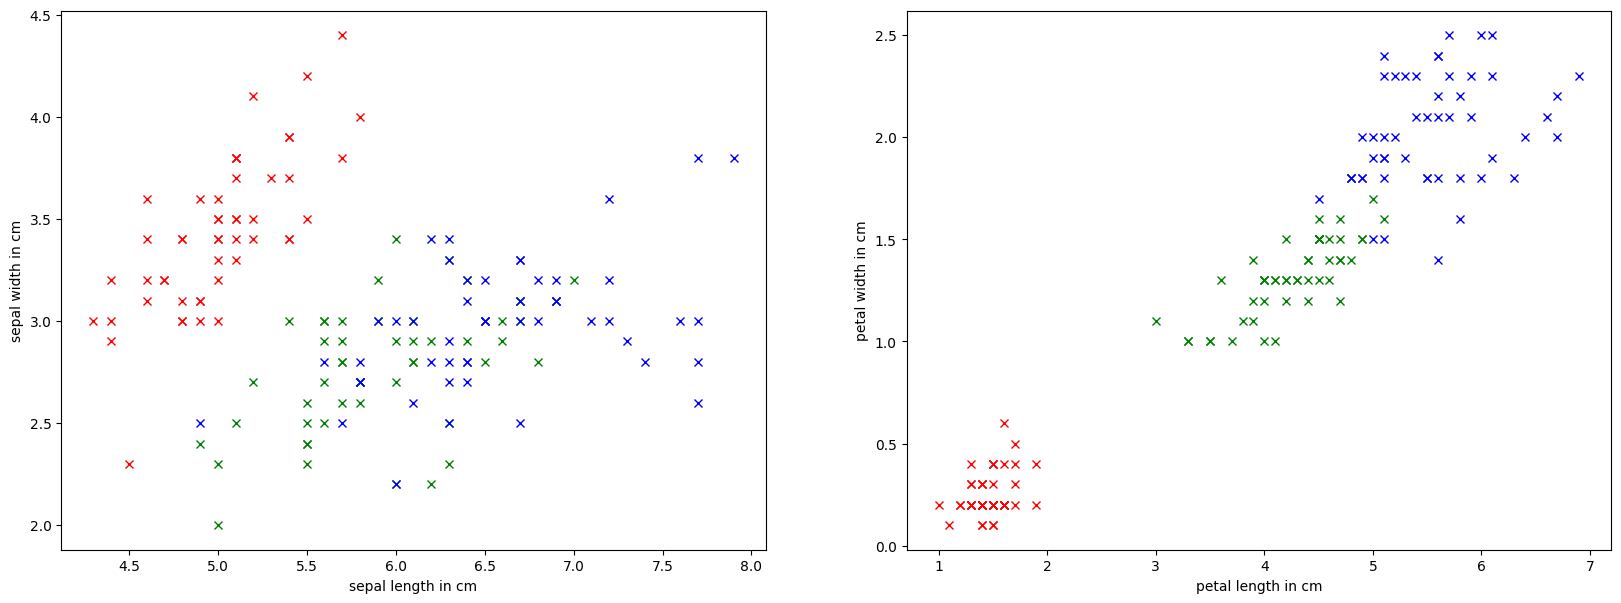

In [ ]:
### chargement du  dataset Iris ###
# informations https://archive.ics.uci.edu/ml/datasets/iris
iris = ds.load_iris()  #150 instances
features_iris = iris.data  #features dimension 4 : [sepal length in cm, sepal width in cm, petal length in cm, petal width in cm]
target_iris= iris.target # 3 classes : Iris Setosa, Iris Versicolour, Iris Virginica / label = {0,1,2}
print(np.shape(features_iris),np.shape(target_iris)) # donc dimensions : features = 150x4, label = 150x1

StylePlot=['xr','xg','xb']  #croix rouge,verte,bleue pour visualiser les 3 classes

plt.figure(2, figsize=(20,7))

plt.subplot(121)
for i in range(len(features_iris)):
  plt.plot(features_iris[i][0],features_iris[i][1],StylePlot[target_iris[i]])
plt.xlabel('sepal length in cm')
plt.ylabel('sepal width in cm')

plt.subplot(122)
for i in range(len(features_iris)):
  plt.plot(features_iris[i][2],features_iris[i][3],StylePlot[target_iris[i]])
plt.xlabel('petal length in cm')
plt.ylabel('petal width in cm')
plt.show()

Algorithme K-means de Scikit-learn

In [ ]:
# A commenter/decommenter pour normaliser ou non les données
#features_iris = prprc.scale(features_iris)

modelKmeans = clstr.KMeans(n_clusters=3)
modelKmeans.fit(features_iris)

### Test clustering ###
predictions = modelKmeans.predict(features_iris)
err = 0
for i in range(len(target_iris)):
  if predictions[i] != target_iris[i] :
            err += 1

print('Error rate (%) :', 100 * err / len(target_iris))

# Sauf coup de chance, le % d'erreur est élevé !
# que s'est-il produit ? : traçons la matrice de confusion pour comprendre !

Error rate (%) : 98.0


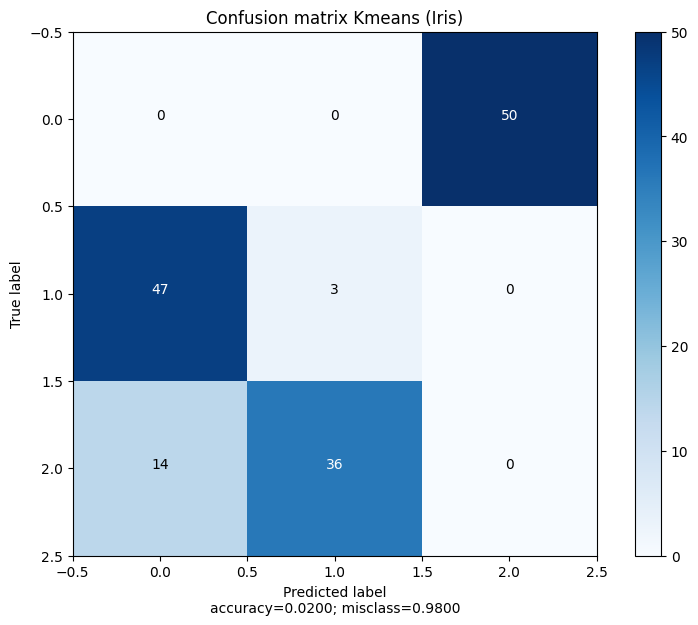

In [ ]:
cmKmeans=confusion_matrix(target_iris,predictions)
Mytitle='Confusion matrix Kmeans (Iris)'
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cmKmeans,title=Mytitle,target_names=None,cmap=Mycmap,normalize=False)

La classification etant ici non supervisée,
**la partition des classes allouées à chaque cluster, ne correspond (probablement) pas avec les labels. Il y avait 1 chance sur 3!=6 que cela coïncide !**

Essayez d'expliquer ce point et comment cela a été géré dans la cellule ci-dessous


In [ ]:
# gestion de la partition (par permutation des colonnes de cm)
def partitionKmeans(cm,nb_classes):
  cmpartition=np.zeros((nb_classes,nb_classes),int)
  partition=[]
  for j in range(nb_classes):
    ind=np.argmax(cm[:,j])
    partition.append(ind)
    print('Le centroïde ',j,' est renommé en (i.e. correspond à une prédiction de la classe) ', ind)
    cmpartition[:,ind]=cm[:,j]
  return(cmpartition,partition)

cmKmeans_partition,partition=partitionKmeans(cmKmeans,3)
print('Partition (renommer les centroïdes des clusters) =>',partition)
print(cmKmeans_partition)


Le centroïde  0  est renommé en (i.e. correspond à une prédiction de la classe)  1
Le centroïde  1  est renommé en (i.e. correspond à une prédiction de la classe)  2
Le centroïde  2  est renommé en (i.e. correspond à une prédiction de la classe)  0
Partition (renommer les centroïdes des clusters) => [1, 2, 0]
[[50  0  0]
 [ 0 47  3]
 [ 0 14 36]]


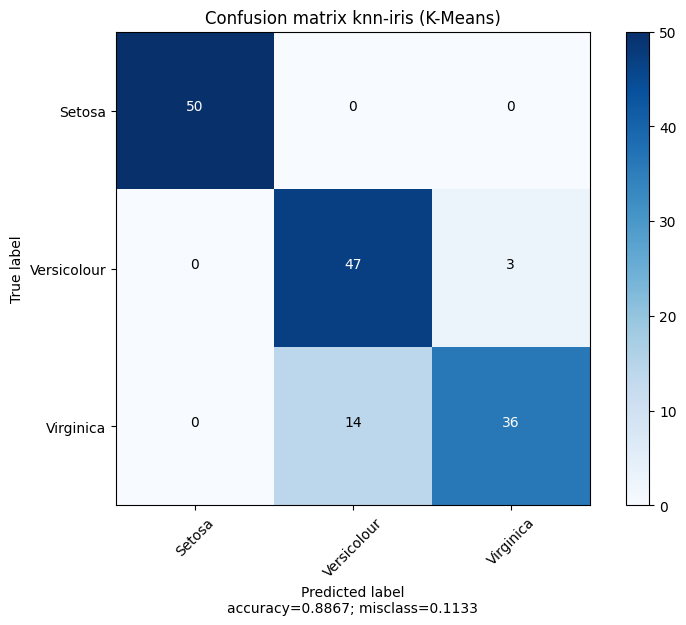

In [ ]:
labelname=['Setosa', 'Versicolour', 'Virginica'] # pour afficher le nom des classes plutôt que le N°
Mytitle='Confusion matrix knn-iris (K-Means)'
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cmKmeans_partition,target_names=labelname,title=Mytitle,cmap=Mycmap,normalize=False)
# normalize : 'False' = résultat en nombre d'occurences , 'True' = resultat en proportion pour chaque classe

Conclusions :
- Aucune confusion pour la classe Setosa.
C'est cohérent avec l'interprétation que nous avions fait en visualisant les features précédemment
- Des confusions plus importantes (que pour knn) apparaissent entre les classes  Versicolour et Virginica.  L'algorithme K-means est ici moins performant que knn pour regrouper/classer les données.


Remarque (non fait ici) : nous pourrions aborder une problème de classification supervisée à N classes, à partir d'un algorithme de classification non supervisée (ici K-means).
La procédure serait donc la suivante :
- déclaration du modèle : modelKmeans = clstr.KMeans(n_clusters=N)
- entraînement du modelMmeans.fit(Xtrain,Ytrain) => centroïdes
- renommage de la partition (allocation des classes à chaque centroïde, par permutation)
- test : Ypred=partition(modelKmmeans.fit(Xtest))
- analyse des résultats : confusion_matrix(Ytest,Ypred) pour voir les capacités de généralisation

... mais cela est rarement fait de la sorte.



In [ ]:
#remarque : pour recupérer les centroïdes du model.fit
centroides=modelKmeans.cluster_centers_
print(centroides[partition])

[[6.85384615 3.07692308 5.71538462 2.05384615]
 [5.006      3.428      1.462      0.246     ]
 [5.88360656 2.74098361 4.38852459 1.43442623]]


Analyse des erreurs

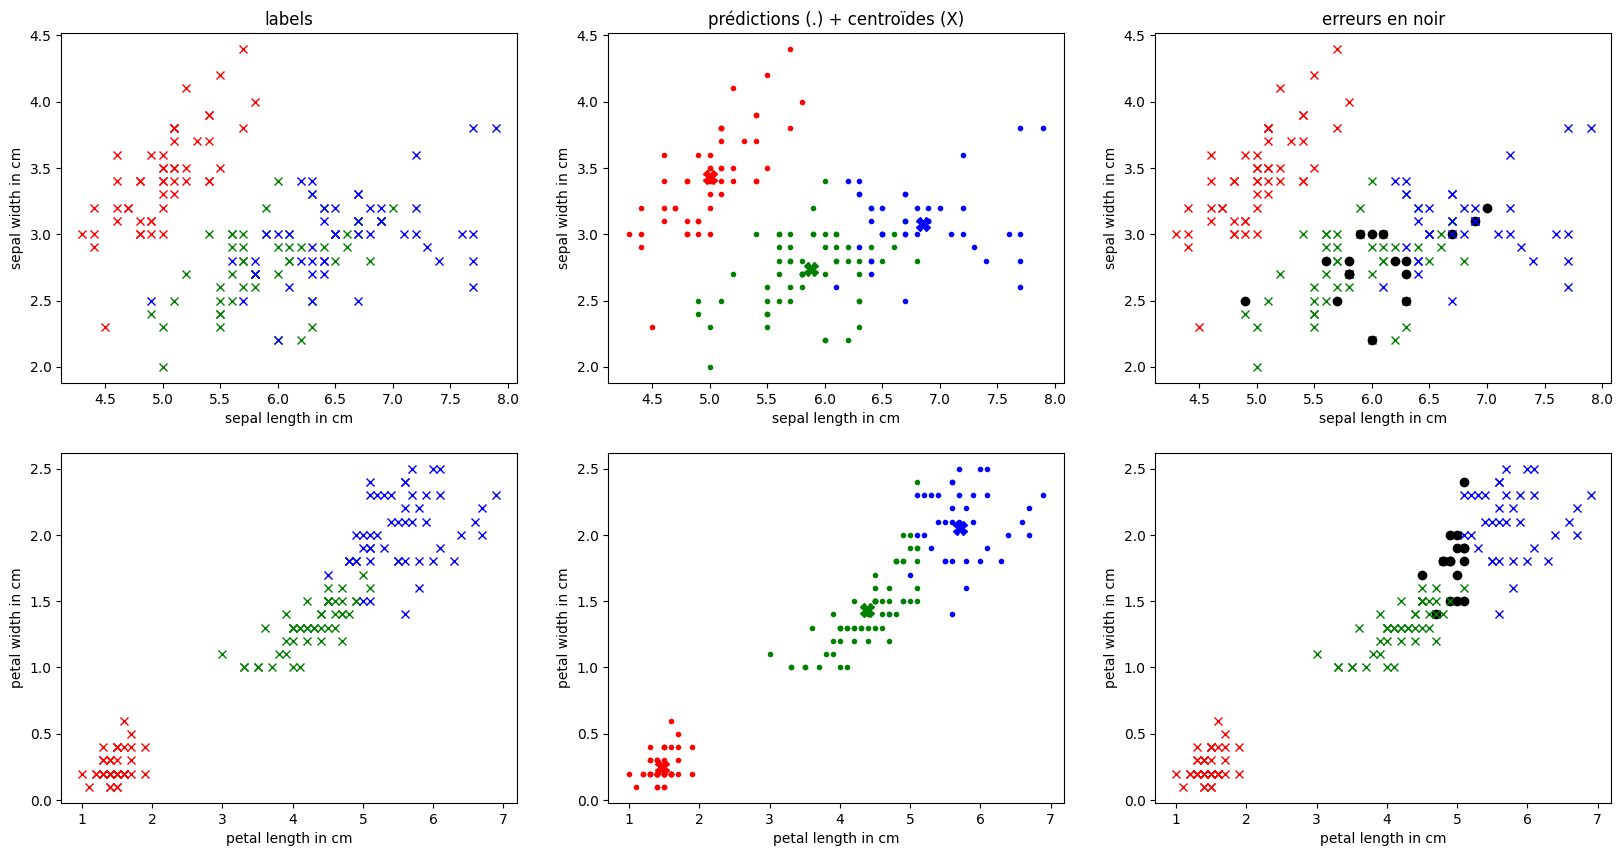

In [ ]:
StylePlot=['xr','xg','xb']  #croix rouge,verte,bleue pour visualiser les 3 classes
StylePlotPred=['.r','.g','.b']
StylePlotCentroides=['Xr','Xg','Xb']


# 1ere colonne : avec les labels théoriques
# 2nde colonne : avec la classification non supervisée (K-means)
# 3eme colonne : les erreurs en noir

erreurs=[]
for i in range(len(target_iris)):
  if (int(partition[predictions[i]]) != target_iris[i]) :  #la prédiction est donc partition[prediction[i]]
    erreurs.append(i)

plt.figure(3, figsize=(20,10))

plt.subplot(231)
for i in range(len(features_iris)):
  plt.plot(features_iris[i][0],features_iris[i][1],StylePlot[target_iris[i]])
plt.xlabel('sepal length in cm')
plt.ylabel('sepal width in cm')
plt.title('labels')

plt.subplot(232)
for i in range(len(features_iris)):
  plt.plot(features_iris[i][0],features_iris[i][1],StylePlotPred[int(partition[predictions[i]])])
for j in range(3):
  plt.plot(centroides[j][0],centroides[j][1],StylePlotCentroides[int(partition[j])],markersize=10)
plt.xlabel('sepal length in cm')
plt.ylabel('sepal width in cm')
plt.title('prédictions (.) + centroïdes (X)')

plt.subplot(233)
for i in range(len(features_iris)):
  if i in erreurs :
    plt.plot(features_iris[i][0],features_iris[i][1],'ok')
  else :
    plt.plot(features_iris[i][0],features_iris[i][1],StylePlot[target_iris[i]])
plt.xlabel('sepal length in cm')
plt.ylabel('sepal width in cm')
plt.title('erreurs en noir')

plt.subplot(234)
for i in range(len(features_iris)):
  plt.plot(features_iris[i][2],features_iris[i][3],StylePlot[target_iris[i]])
plt.xlabel('petal length in cm')
plt.ylabel('petal width in cm')

plt.subplot(235)
for i in range(len(features_iris)):
  plt.plot(features_iris[i][2],features_iris[i][3],StylePlotPred[int(partition[predictions[i]])])
for j in range(3):
  plt.plot(centroides[j][2],centroides[j][3],StylePlotCentroides[int(partition[j])],markersize=10)
plt.xlabel('petal length in cm')
plt.ylabel('petal width in cm')

plt.subplot(236)
for i in range(len(features_iris)):
  if i in erreurs :
    plt.plot(features_iris[i][2],features_iris[i][3],'ok')
  else :
    plt.plot(features_iris[i][2],features_iris[i][3],StylePlot[target_iris[i]])
plt.xlabel('petal length in cm')
plt.ylabel('petal width in cm')
plt.show()


# Reseau de neurones Dense pour la classification supervisée

Mise au format des données pour le reseau de neurones

In [ ]:
tot=len(target_iris)
N=100  # nombre de données de train / donc tot-N données de test
Xtrain=shuffled_features_iris[0:N]
Ytrain=shuffled_target_iris[0:N]
Xtest=shuffled_features_iris[N:tot]
Ytest=shuffled_target_iris[N:tot]

print('shape avant mise au format : entrées=',np.shape(Xtrain),np.shape(Xtest),' sorties=',np.shape(Ytrain),np.shape(Ytest))

# Codage des sorties label => vecteur
#attention ! : vous devez bien comprendre ce que font ces lignes de code
#              ... et comprendre pourquoi il faudra utiliser Ytest et non Ytest_nn pour la matrice de confusion !
Ytrain_nn=to_categorical(Ytrain)
Ytest_nn=to_categorical(Ytest)
print('shape sorties après mise au format :=',np.shape(Ytrain_nn),np.shape(Ytest_nn))

shape avant mise au format : entrées= (100, 4) (50, 4)  sorties= (100,) (50,)
shape sorties après mise au format := (100, 3) (50, 3)


Nous vérifions que la réparition dans les bases de train et de test est suffisamment homogène (représentation similaire dans chacune des classes, disons à 3 unités près pour Train). Si ce n'est pas la cas, nous générons une nouvelle repartition aléatoire "shuffle"

In [ ]:
Nbclasses=3
print('repartition par classes. pour Train =',OccurencesClasses(Ytrain,Nbclasses))
print('repartition par classes. pour Test =',OccurencesClasses(Ytest,Nbclasses))

repartition par classes. pour Train = [33 34 33]
repartition par classes. pour Test = [17 16 17]


Création du reseau de neurones Dense.

La couche de sortie doit contenir autant de neurones qu'il y a de classes, avec une fonction d'activation softmax

*   Pour la fonction de loss et la métrique, nous choisissons " : 'categorical_crossentropy' https://keras.io/api/losses/
    et 'Adam' pour optimizer : https://keras.io/api/optimizers/


In [ ]:
Model = Sequential()
Model.add(Dense(8, input_dim=4, activation='relu'))
Model.add(Dense(12, activation='relu'))
Model.add(Dropout(0.3))
Model.add(Dense(8, activation='relu'))
Model.add(Dense(3, activation='softmax'))

Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 8)                   │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 279 (1.09 KB)

 Trainable params: 279 (1.09 KB)

 Non-trainable params: 0 (0.00 B)

Entrainement du reseau de neurones et sauvegarde des poids

In [ ]:
history = Model.fit(Xtrain,Ytrain_nn, epochs=100, batch_size=10,
                    validation_data=(Xtest,Ytest_nn), verbose=1)

# Evaluation des performances du modèles sur les données de test
print('accuracy sur les données de test')
_, acc = Model.evaluate(Xtest,Ytest_nn)
print('> %.3f' % (acc * 100.0))

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.2901 - loss: 1.3489 - val_accuracy: 0.3200 - val_loss: 1.2499
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3245 - loss: 1.2296 - val_accuracy: 0.3200 - val_loss: 1.1783
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3164 - loss: 1.2110 - val_accuracy: 0.3200 - val_loss: 1.1355
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3400 - loss: 1.1350 - val_accuracy: 0.3200 - val_loss: 1.1103
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3164 - loss: 1.1353 - val_accuracy: 0.3200 - val_loss: 1.0937
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3707 - loss: 1.1177 - val_accuracy: 0.3200 - val_loss: 1.0867
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3289 - loss: 1.1119 - val_accuracy: 0.3200 - val_loss: 1.0797
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3882 - loss: 1.0915 - val_accuracy: 0.3200 - 

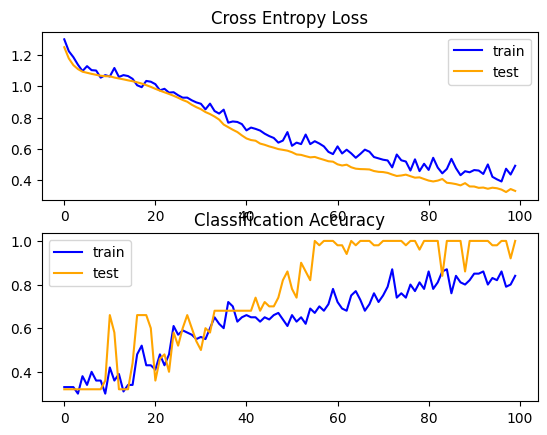

In [ ]:
# Sauvegarde du jeu de poids du modèle entraîné
filename="weightsIris"
Model.save_weights("{}/{}.weights.h5".format(working_dir,filename))
# Courbes d'évoluation de la loss et de l'accuracy au cours des époques, sur les données de train et de test
summarize_diagnostics_classif(history,working_dir,filename)

Predictions et matrice de confusion

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[17  0  0]
 [ 0 16  0]
 [ 0  0 17]]


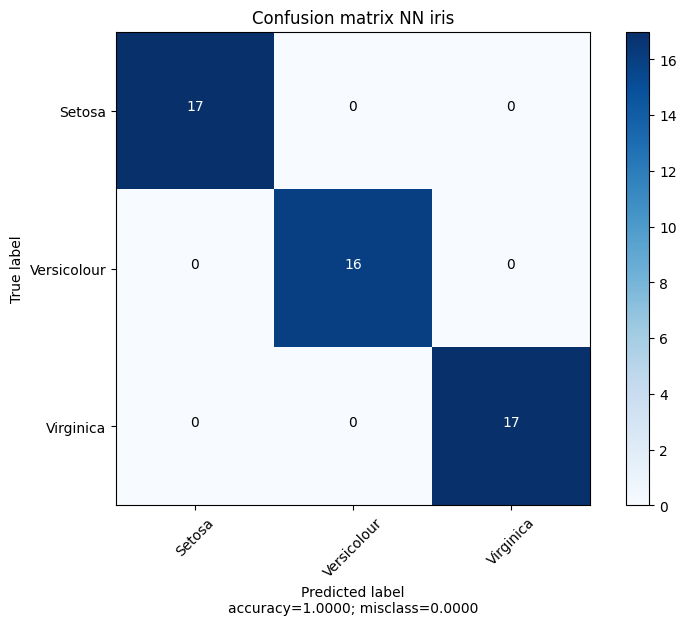

In [ ]:
# Prédictions sur les données de test et  matrice de confusion
y_pred=Model.predict(Xtest)
Y_pred = np.argmax(y_pred, 1) # sortie softmax -> prédiction

cm=confusion_matrix(Ytest,Y_pred)
print(cm)

labelname=['Setosa', 'Versicolour', 'Virginica'] # pour afficher le nom des classes plutôt que le N°
Mytitle='Confusion matrix NN iris'
Mycmap='Blues'    #personnalisation de la couleur : https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html  (par défaut = Blues)
plot_confusion_matrix(cm,target_names=labelname,title=Mytitle,cmap=Mycmap,normalize=False)  #normalize : 'False' = résultat en nombre d'occurences , 'True' = resultat en proportion pour chaque classe

# Regression par réseau dense

Pour une regression, la sortie est une valeur ou une liste de valeurs à prédire.
La dernière couche est de dimension égale aux nombre de valeurs prédites, avec une fonction d'activation qui dépend de la plage des valeurs de sorties.
Exemples :
-  aucune si les valeurs sont positives et négatives, sans bornes a priori
- 'relu' si les valeurs sont strictement positives, non bornées à priori  
- 'sigmoid' si les valeurs de sorties sont comprises entre 0 et 1
-  'tanh' si les valeurs de sorties sont comprises entre -1 et 1
- ...

La loss utilisée https://keras.io/api/losses/ (Regression losses) est par exemple "mean_squared_error", "mean_absolute_error ", ...


Exercice : transformer le problème de classification étudié en un problème de regression.  
Vous devez constater que pour le problème étudié, cela se passe très bien !

In [ ]:
ModelReg = Sequential()
ModelReg.add(Dense(8, input_dim=4, activation='relu'))
ModelReg.add(Dense(12, activation='relu'))
ModelReg.add(Dense(8, activation='relu'))
ModelReg.add(Dense(1))

ModelReg.compile(optimizer='adam', loss='mean_squared_error')
ModelReg.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 12)                  │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 8)                   │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 261 (1.02 KB)

 Trainable params: 261 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = ModelReg.fit(Xtrain,Ytrain, epochs=100, batch_size=10,
                    validation_data=(Xtest,Ytest), verbose=1)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 11.2209 - val_loss: 7.7071
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9199 - val_loss: 5.1194
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2301 - val_loss: 3.2728
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4084 - val_loss: 1.8262
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3192 - val_loss: 0.8357
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5501 - val_loss: 0.3590
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2882 - val_loss: 0.2092
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1862 - val_loss: 0.1692
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1612 - val_loss: 0.1472
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1366 - val_loss: 0.1299
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1361 - val_loss: 0.1135
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0

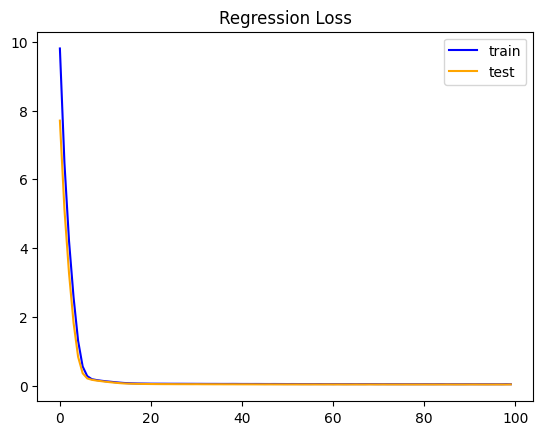

In [ ]:
# evaluate model
filename="weightsIris-Reg"
ModelReg.save_weights("{}/{}.weights.h5".format(working_dir,filename))
# learning curve
summarize_diagnostics_reg(history,working_dir,filename)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


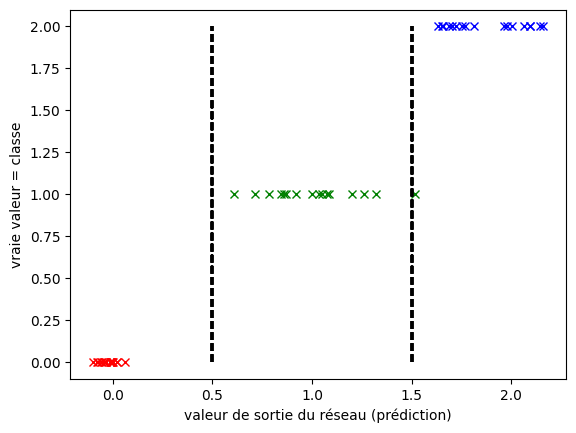

In [ ]:
Yout=ModelReg.predict(Xtest)

StylePlot=['xr','xg','xb']  #croix rouge,verte,bleue pour visualiser les 3 classes
plt.figure()
for i in range(tot-N):
  plt.plot(Yout[i],Ytest[i],StylePlot[Ytest[i]])
  plt.plot((0.5,0.5),(0,2),'--k')
  plt.plot((1.5,1.5),(0,2),'--k')
plt.xlabel('valeur de sortie du réseau (prédiction)')
plt.ylabel('vraie valeur = classe')
plt.show()

Cela marche bien ici ! Juste quelques confusions entre les classes 1 et 2 (i.e. autour du "seuil Yout=1.5")
Attribuons pour prédiction de la classe celle la plus proche de la sortie Yout

In [ ]:
def Reg2Classif(Yout):
  Ypred=np.zeros(len(Yout))
  for i in range(len(Yout)):
    Ypred[i]=np.argmin([np.abs(Yout[i]-k) for k in  np.arange(3) ])  # np.arange(3) => [0,1,2]
  return(Ypred)

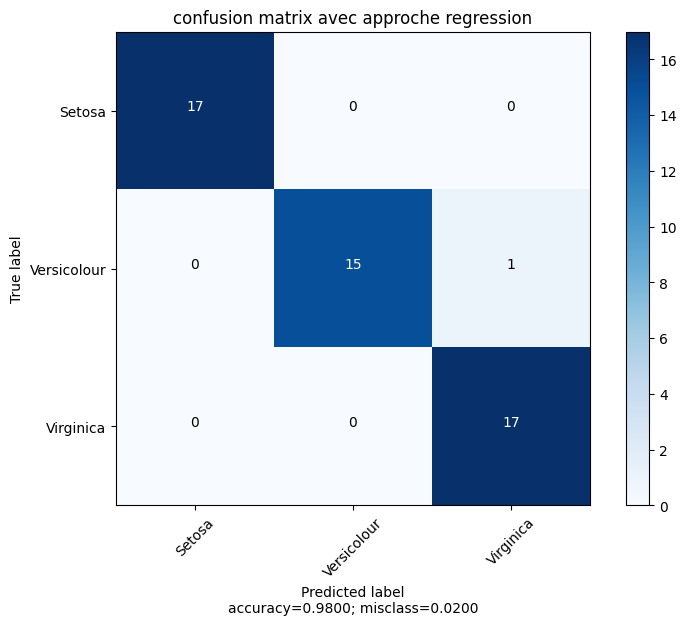

In [ ]:
Mytitle='confusion matrix avec approche regression'
Yreg2pred=Reg2Classif(Yout)
plot_confusion_matrix(confusion_matrix(Ytest,Yreg2pred),title=Mytitle,target_names=labelname,cmap=Mycmap,normalize=False)
